In [1]:
%matplotlib inline

from glob import glob

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import warnings
from functools import partial

Open a couple datasets, and plot each of them individually, and combined. Next step is to take a list of filenames and generate all of them individually, plus the summed 2D histograms.

In [4]:
all_histos_both_melt = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*.nc'))
const_melt_histos = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*4400.nc'))
# The 4 June case has the same melting height our constant case
vary_melt_histos = sorted([hf for hf in all_histos_both_melt if not(hf in const_melt_histos)] 
                    + glob('/efs/tracer/NEXRAD/tobac_Save_20220604/histogram_data*4400.nc')
                          + glob('/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data*4400.nc')
                         )

all_histos_both_melt = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*.nc'))
const_melt_histos = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*4400.nc'))
# The 4 June case has the same melting height our constant case
# vary_melt_histos =  glob('/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data*4400.nc')
# const_melt_histos =  glob('/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data*4400.nc')

for hf in zip(const_melt_histos, vary_melt_histos):
    print(hf)
print(len(vary_melt_histos), len(const_melt_histos))
# assert len(vary_melt_histos) == len(const_melt_histos)

const_melt = True
if const_melt:
    all_histos = const_melt_histos
else:
    all_histos = vary_melt_histos

('/efs/tracer/NEXRAD/tobac_Save_20220602/histogram_data_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220604/histogram_data_melt4400.nc')
('/efs/tracer/NEXRAD/tobac_Save_20220604/histogram_data_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data_melt4400.nc')
2 24


In [5]:
histo_ds2 = xr.open_dataset(all_histos[0])

In [6]:
def aggregate_histos(histo_filenames):
    histo_iter = (xr.open_dataset(fn) for fn in histo_filenames)
    cleaned = [ds.drop(['grid_time_start', 'grid_time_end']) for ds in histo_iter]
    N_histos = len(histo_filenames)
    ds = xr.combine_nested(cleaned, concat_dim='day', combine_attrs='override').sum(dim='day', keep_attrs=True)
    
    # Find the mean of the percentiles on each day.
    percentile_vars = [v for v in list(ds.variables.keys()) if 'percentile' in v]
    for v in percentile_vars:
        if 'thresholds' in v:
             pass
        else:
            ds[v] /= N_histos
    ds['track_maximum_distance_km'] /= N_histos
            
    return ds

In [7]:
agg_histo_ds = aggregate_histos(all_histos)

In [8]:
agg_histo_ds

<xarray.Dataset>
Dimensions:                                                                                 (
                                                                                             feature_flash_count_area_time_norm_bin: 21,
                                                                                             feature_kdpcol_area_time_norm_bin: 21,
                                                                                             feature_kdpcol_total_area_time_norm_bin: 21,
                                                                                             feature_kdpvol_area_time_norm_bin: 21,
                                                                                             feature_kdpwt_total_area_time_norm_bin: 21,
                                                                                             ...
                                                                                             feature_zdrwt_total_area_time_norm_bin: 21,
                                                                                             feature_flash_count_bin: 21,
                                                                                             feature_kdpcol_bin: 21,
                                                                                             feature_zdrvol_bin: 21,
                                                                                             percentile_thresholds: 3,
                                                                                             track_count: 1)
Coordinates: (12/19)
  * feature_flash_count_area_time_norm_bin                                                  (feature_flash_count_area_time_norm_bin) float64 ...
  * feature_kdpcol_area_time_norm_bin                                                       (feature_kdpcol_area_time_norm_bin) float64 ...
  * feature_kdpcol_total_area_time_norm_bin                                                 (feature_kdpcol_total_area_time_norm_bin) float64 ...
  * feature_kdpvol_area_time_norm_bin                                                       (feature_kdpvol_area_time_norm_bin) float64 ...
  * feature_kdpwt_total_area_time_norm_bin                                                  (feature_kdpwt_total_area_time_norm_bin) float64 ...
  * feature_nearby_count_10km_bin                                                           (feature_nearby_count_10km_bin) float64 ...
    ...                                                                                      ...
  * feature_zdrwt_total_area_time_norm_bin                                                  (feature_zdrwt_total_area_time_norm_bin) float64 ...
  * feature_flash_count_bin                                                                 (feature_flash_count_bin) float64 ...
  * feature_kdpcol_bin                                                                      (feature_kdpcol_bin) float64 ...
  * feature_zdrvol_bin                                                                      (feature_zdrvol_bin) float64 ...
  * percentile_thresholds                                                                   (percentile_thresholds) int64 ...
  * track_count                                                                             (track_count) int64 ...
Data variables: (12/158)
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_area_time_norm              (feature_flash_count_area_time_norm_bin, feature_kdpcol_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_total_area_time_norm        (feature_flash_count_area_time_norm_bin, feature_kdpcol_total_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpvol_area_time_norm              (feature_flash_count_area_time_norm_bin, feature_kdpvol_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpwt_total_area_time_norm         (

# Plotting from the standardized histogram dataset

In [9]:
def track_count_table(histo_ds):
    all_dims = list(histo_ds.dims.keys())
    dims_to_remove = [d for d in all_dims if d != 'track_count']
    ds = histo_ds.drop_dims(dims_to_remove)
    return ds.to_dataframe()

In [10]:
track_count_table(histo_ds2)

,grid_time_start,grid_time_end,track_has_zdr_kdp_ltg,track_has_zdr_kdp_only,track_has_zdr_ltg_only,track_has_zdr_only,track_has_nothing,track_has_kdp_only,track_has_kdp_ltg_only,track_has_ltg_only,track_maximum_distance_km
track_count,,,,,,,,,,,
0,2022-06-02 00:05:22.842,2022-06-02 23:57:07.178,60,50,6,23,37,0,0,0,90.0


In [11]:
track_count_table(agg_histo_ds)

,track_has_zdr_kdp_ltg,track_has_zdr_kdp_only,track_has_zdr_ltg_only,track_has_zdr_only,track_has_nothing,track_has_kdp_only,track_has_kdp_ltg_only,track_has_ltg_only,track_maximum_distance_km
track_count,,,,,,,,,
0,1554,331,508,368,4517,0,0,0,90.0


In [12]:
def plot_1d_hists(histo_ds):
    all_dims = list(histo_ds.dims.keys())
    dims_to_remove = [d for d in all_dims if d != 'percentile_thresholds']
    try:
        percentile_ds = histo_ds.drop_dims(dims_to_remove).drop('grid_time_start').drop('grid_time_end')
    except ValueError:
        print("Not dropping grid time start and end - not in the dataset")
        percentile_ds = histo_ds.drop_dims(dims_to_remove)
    percentile_ds = percentile_ds.drop('track_maximum_distance_km')
    
    for var in percentile_ds:
        bins = histo_ds[var.replace('percentile_','')+'_bin']
        counts = histo_ds[var.replace('percentile_','')]
        description = counts.attrs['long_name']
        fig, ax = plt.subplots(1,1)

        # print(var, bins.values[0], counts.values[0], percentile_ds[var].values)
        # ax.step(bins, counts, where='mid')
        ax.fill_between(bins, counts, step='mid')
        for thresh, thresh_val in zip(percentile_ds['percentile_thresholds'].values, percentile_ds[var].values):
            ax.axvline(thresh_val, color='k', linewidth=0.5)
            ax.text(thresh_val, counts.max()*.9, f' {thresh_val:3.2e}')
        # ax.set_xlim(-1,15)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel("Number of tracks")
        ax.set_xlabel(description)
        ax.set_title("Track property distribution")

Not dropping grid time start and end - not in the dataset


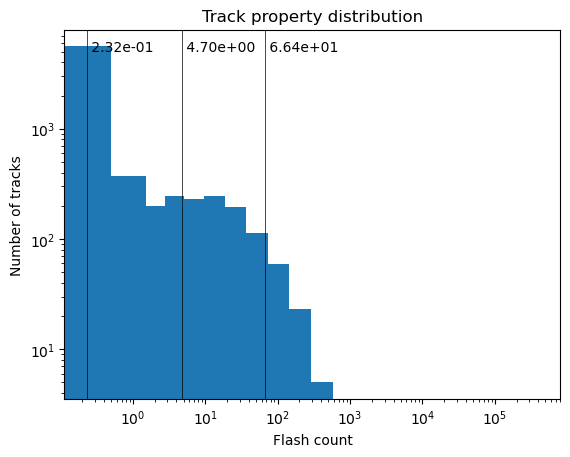

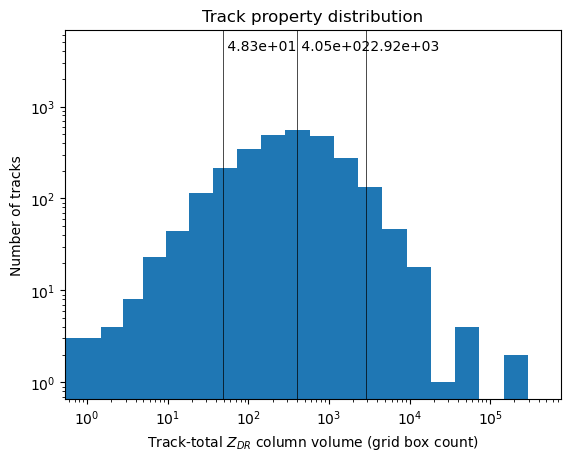

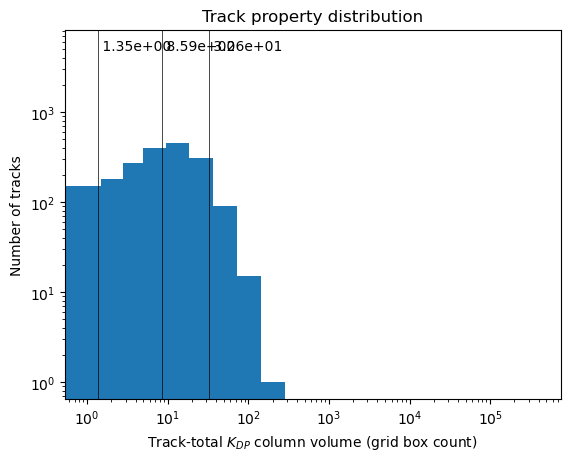

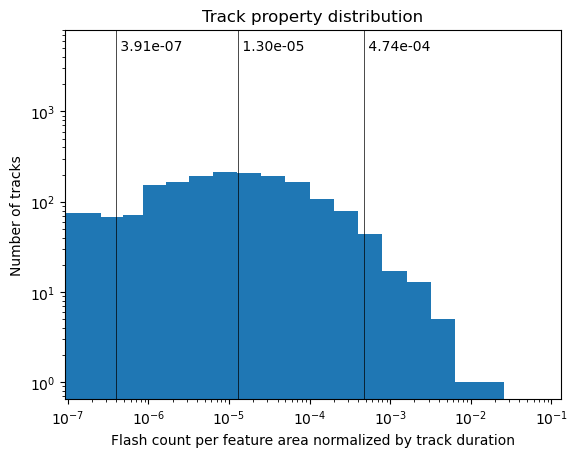

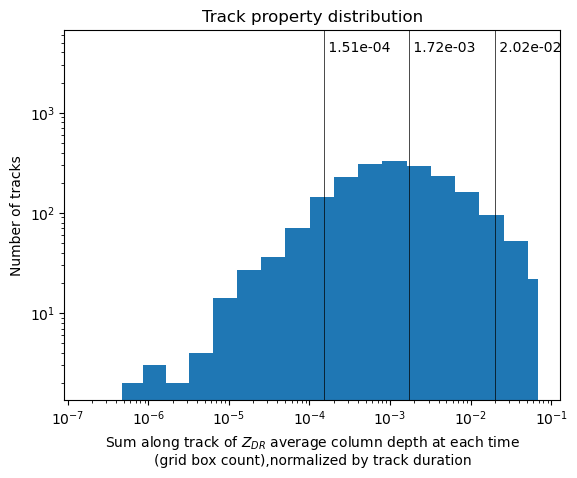

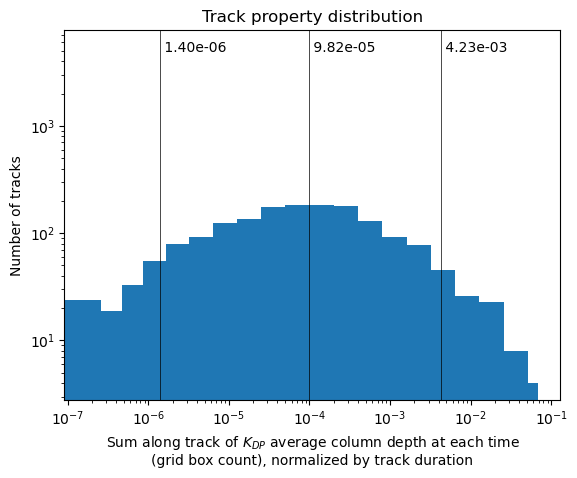

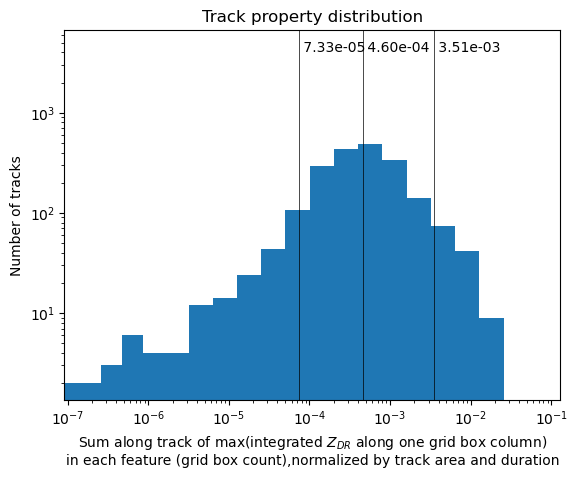

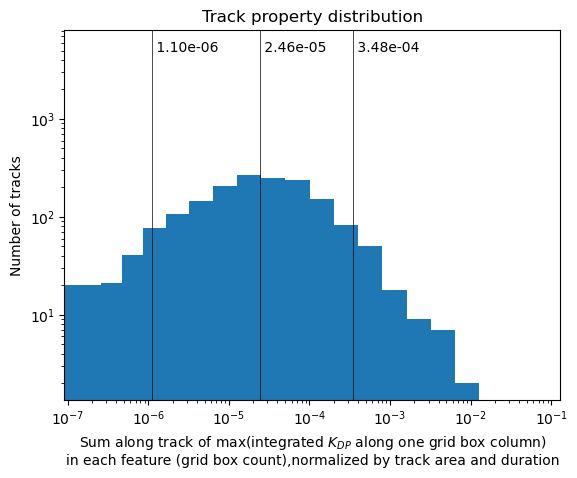

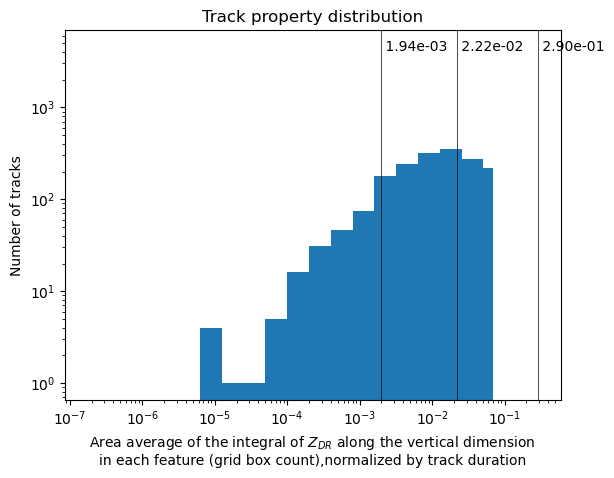

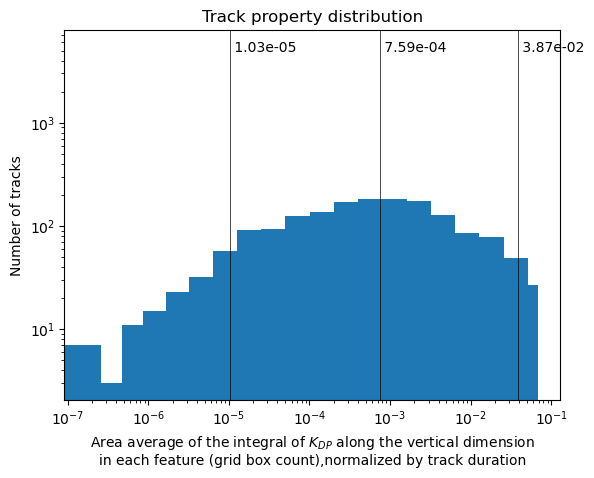

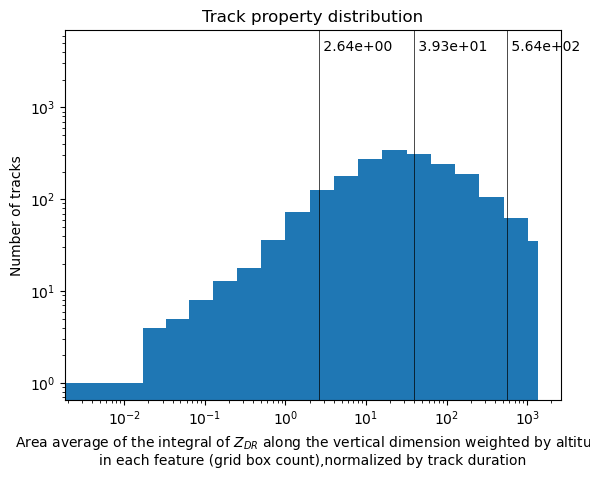

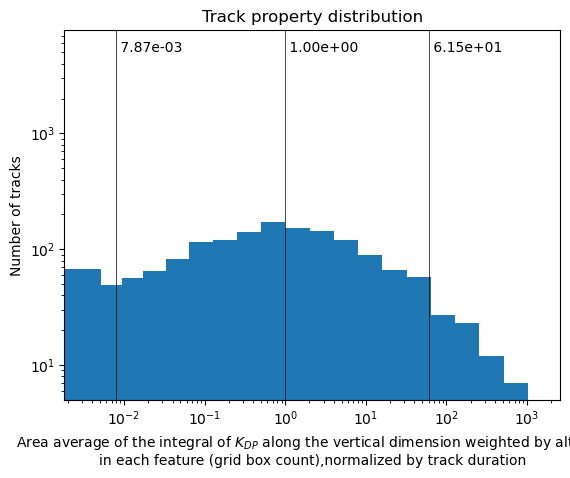

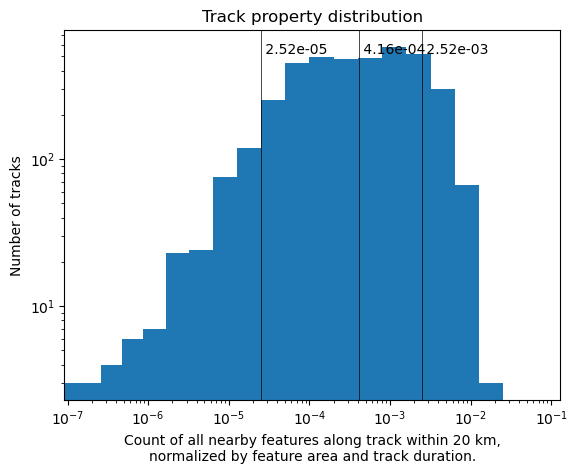

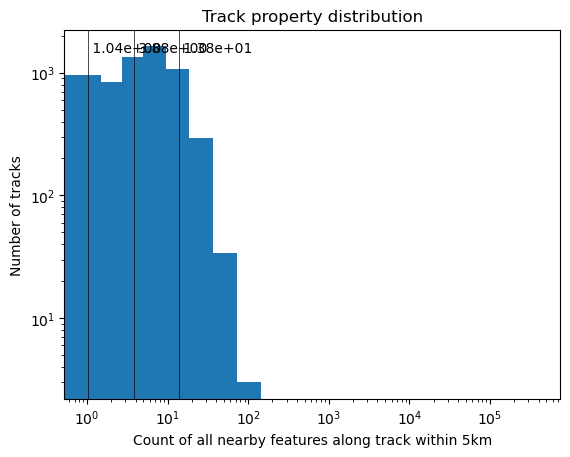

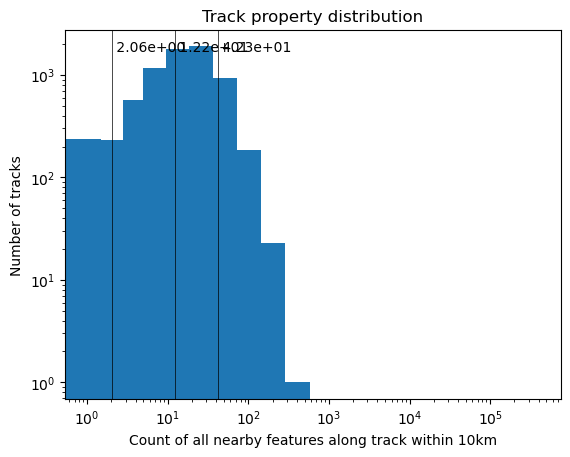

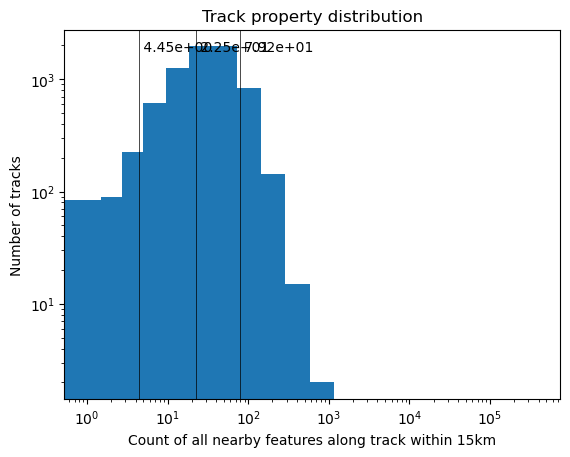

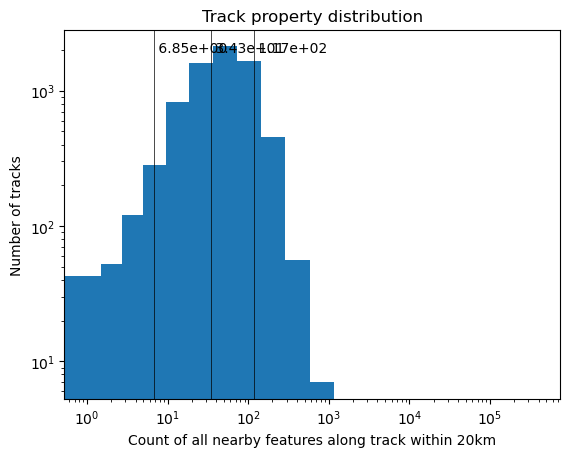

In [13]:
plot_1d_hists(agg_histo_ds)

In [14]:
# plot_1d_hists(histo_ds2)

In [23]:
def plot_2d_hists(histo_ds_all, plot_hist_names=None):
    # Look at a representative dataset
    histo_ds = histo_ds_all[0]
    # Find the 2D histogram variables
    all_histo_names = sorted(k for k in histo_ds.data_vars.keys() if (len(histo_ds[k].dims)==2))

    # only plot the normed histograms
    if plot_hist_names is None:
        plot_hist_names = [s for s in all_histo_names if s.count('norm') == 2]
    
    hist_count = len(plot_hist_names)
    combo_rows = int(np.ceil(hist_count/3))
    fig, axs = plt.subplots(combo_rows,3, figsize=(2*8, 2*combo_rows*2))
    all_axs = axs.flatten()
    
    for axi, var_name in enumerate(plot_hist_names):
        all_h = sum(hds[var_name] for hds in histo_ds_all)
        h = histo_ds[var_name]
        ax = all_axs[axi]
        bins = h[h.coords.dims[0]].values, h[h.coords.dims[1]].values
        all_h.T.plot(levels=33, vmin=0, vmax=64, ax=ax)
        # Need to have the lower limit be the first bin so that it's nonnegative.
        ax.axis((bins[0][1]/10, bins[0][-1], 2*bins[1][1]/10, 2*bins[1][-1]))
        # ax.axis((0.1, 2048, 0.1, 2048))
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.tight_layout()
    return fig

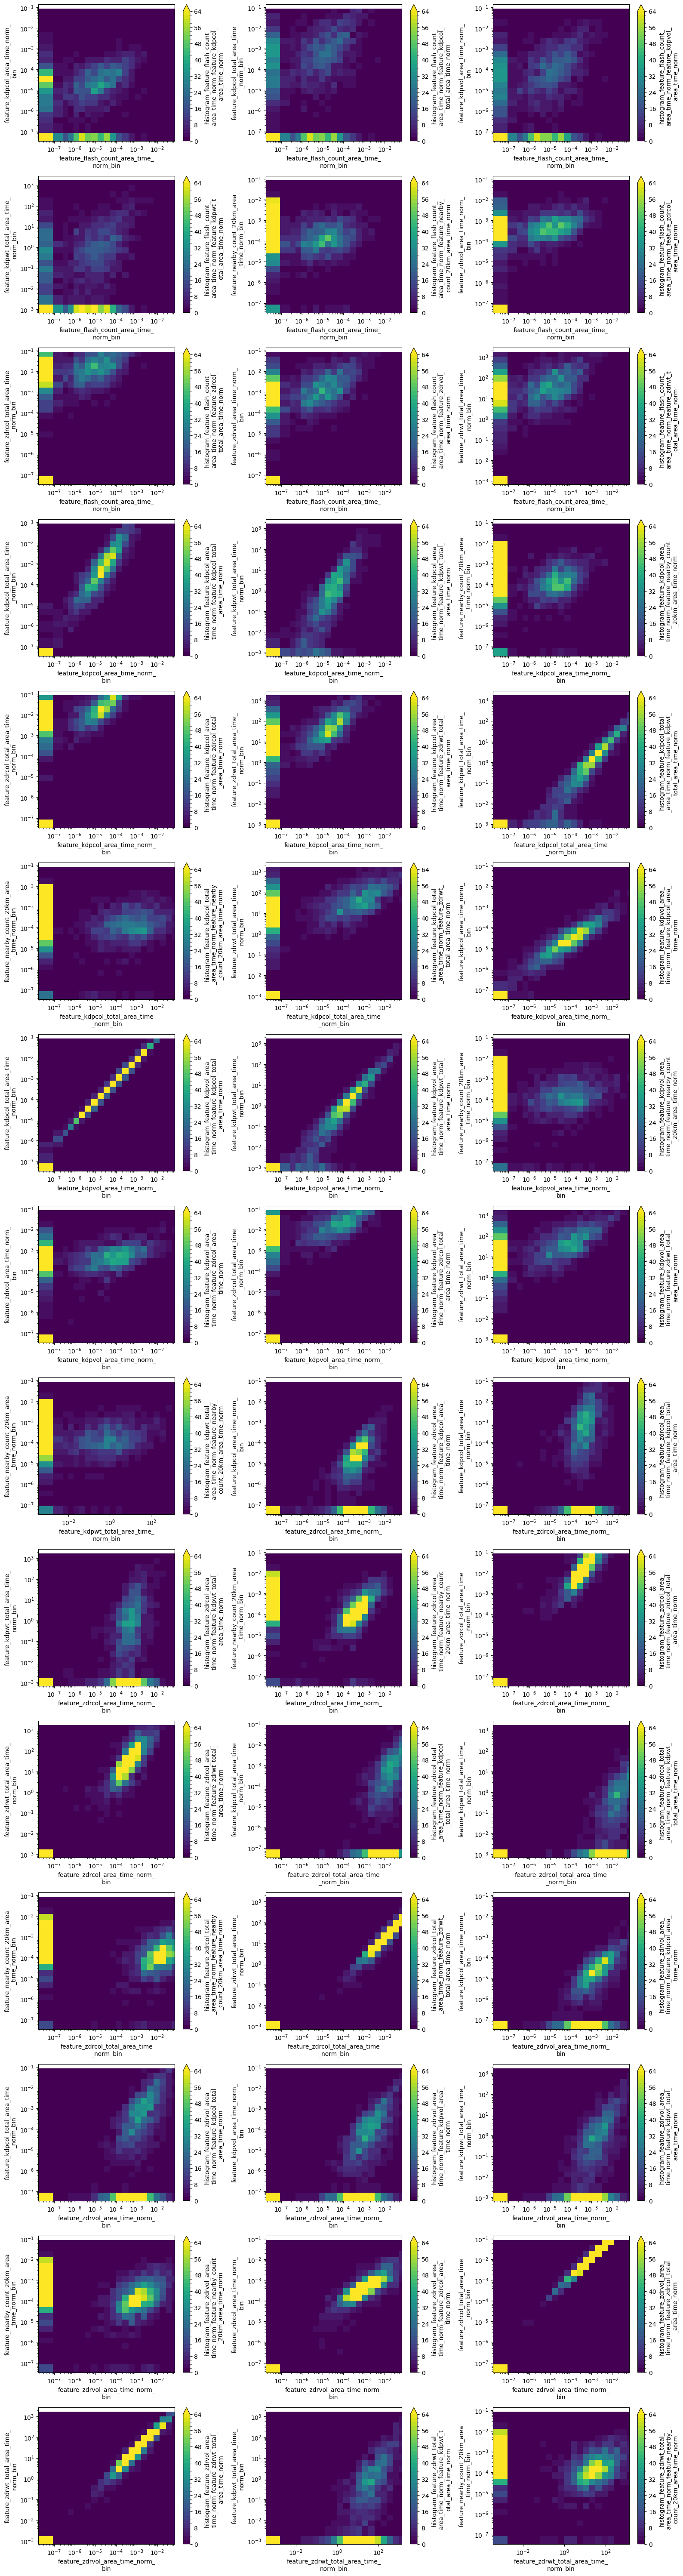

In [24]:
fig = plot_2d_hists([agg_histo_ds])
if const_melt:
    fig.savefig('joint_histos_constmelt.pdf')
else:
    fig.savefig('joint_histos_varymelt.pdf')

In [17]:
# plot_2d_hists([histo_ds2])

In [18]:
# plot_2d_hists([histo_ds, histo_ds2])